<a href="https://colab.research.google.com/github/MUbarak123-56/qiskit-work/blob/master/qml/effective_dim_qnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc
#!pip install git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src
!pip install -q qiskit-aer
!pip install -q qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.utils import algorithm_globals
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# set random seed
algorithm_globals.random_seed = 42

<ipython-input-2-398a119bedc9>:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA


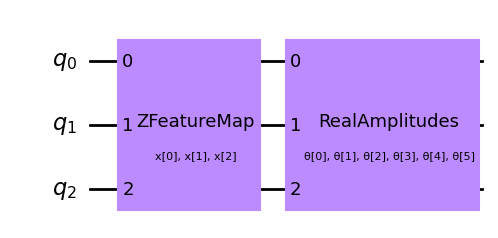

In [3]:
num_qubits = 3
# create a feature map
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)
# create a variational circuit
ansatz = RealAmplitudes(num_qubits, reps=1)

# combine feature map and ansatz into a single circuit
qc = QuantumCircuit(num_qubits)
qc.append(feature_map, range(num_qubits))
qc.append(ansatz, range(num_qubits))
qc.decompose().draw("mpl")

In [4]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [5]:
# construct QNN
qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
)

### Global Effective Dimension Example

In [6]:
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 10
num_weight_samples = 10

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

In [7]:
# we can also provide user-defined samples and parameters
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)

In [8]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

In [9]:
global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

In [10]:
d = qnn.num_weights

print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
print(
    "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
)

Data size: 5000, global effective dimension: 4.6657
Number of weights: 6, normalized effective dimension: 0.7776


In [11]:
global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)

In [12]:
print("Effective dimension: {}".format(global_eff_dim_1))
print("Number of weights: {}".format(d))

Effective dimension: [4.66565096 4.7133723  4.73782922 4.89963559 4.94632272 5.00280009
 5.04530433 5.07408394 5.15786005 5.21349874]
Number of weights: 6


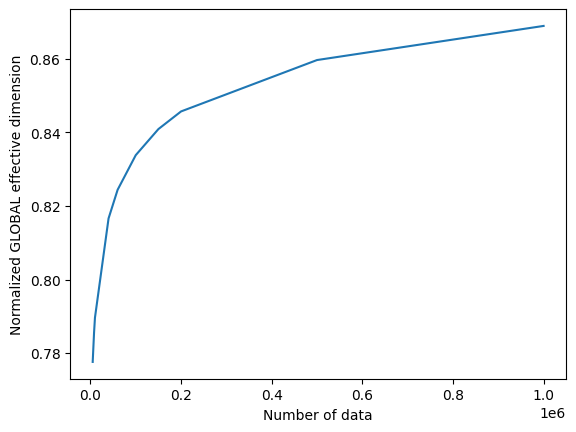

In [13]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()

#### Local Effective Dimension Example

In [14]:
num_inputs = 3
num_samples = 50

X, y = make_classification(
    n_samples=num_samples,
    n_features=num_inputs,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
)
X = MinMaxScaler().fit_transform(X)
y = 2 * y - 1  # labels in {-1, 1}

In [15]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [16]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [17]:
# construct classifier
initial_point = algorithm_globals.random.random(estimator_qnn.num_weights)

estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=COBYLA(maxiter=80),
    initial_point=initial_point,
    callback=callback_graph,
)

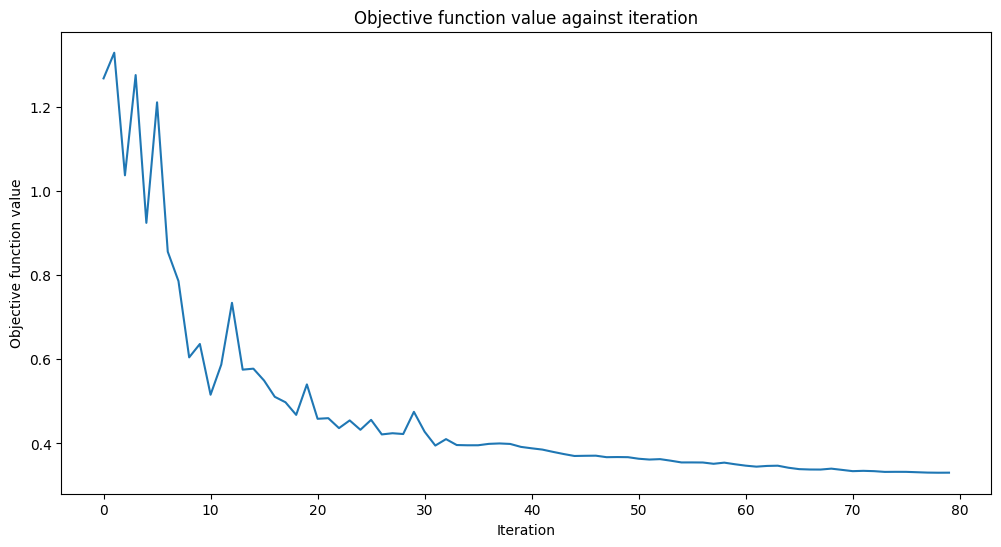

In [18]:
# create empty array for callback to store evaluations of the objective function (callback)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [19]:
# score classifier
estimator_classifier.score(X, y)

1.0

#### Local Effective Dimension for trained QNN

In [20]:
trained_weights = estimator_classifier.weights

# get Local Effective Dimension for set of trained weights
local_ed_trained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=trained_weights, input_samples=X
)

local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for trained QNN: ",
    local_eff_dim_trained / estimator_qnn.num_weights,
)

normalized local effective dimensions for trained QNN:  [0.51381156 0.53546036 0.54601169 0.61116252 0.62899355 0.65015131
 0.66581581 0.67631127 0.70643359 0.72615698]


#### Local Effective Dimension on untrained QNN

In [21]:
# get Local Effective Dimension for set of untrained weights
local_ed_untrained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=initial_point, input_samples=X
)

local_eff_dim_untrained = local_ed_untrained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for untrained QNN: ",
    local_eff_dim_untrained / estimator_qnn.num_weights,
)

normalized local effective dimensions for untrained QNN:  [0.65187789 0.66412356 0.67024402 0.71010878 0.72177003 0.73608508
 0.74700821 0.75446931 0.77641592 0.79111253]


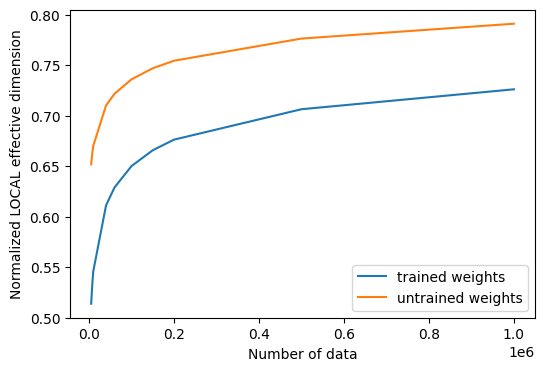

In [22]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(local_eff_dim_trained) / estimator_qnn.num_weights, label="trained weights")
plt.plot(
    n, np.array(local_eff_dim_untrained) / estimator_qnn.num_weights, label="untrained weights"
)

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.show()